# 🔬 PCA Analysis on Standardized Data

This notebook performs PCA analysis on **standardized** joint features to understand:
1. Intrinsic dimensionality of the data
2. Feature redundancy and correlation structure
3. Optimal number of components needed
4. Principal component loadings

**Key difference from previous analysis:** All features are standardized first using StandardScaler to ensure PCA isn't biased by feature scales.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load and Prepare Data

In [2]:
# Load data
train_df = pd.read_csv('../data/pirate_pain_train.csv')
labels_df = pd.read_csv('../data/pirate_pain_train_labels.csv')

# Merge labels
train_df = train_df.merge(labels_df, on='sample_index', how='left')

# Get joint columns
joint_cols = [col for col in train_df.columns if col.startswith('joint_')]

print(f"Dataset shape: {train_df.shape}")
print(f"Number of joint features: {len(joint_cols)}")
print(f"Total samples: {train_df['sample_index'].nunique()}")
print(f"Time steps per sample: {train_df.groupby('sample_index').size().unique()}")
print(f"\nJoint features: {joint_cols}")

Dataset shape: (105760, 41)
Number of joint features: 31
Total samples: 661
Time steps per sample: [160]

Joint features: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_30']


## 2. Standardize Features

**Why standardize?**
- PCA is sensitive to feature scales
- Features with larger variance dominate the principal components
- StandardScaler ensures each feature has mean=0 and std=1

In [3]:
# Extract joint features
X = train_df[joint_cols].values

print("Before Standardization:")
print("="*60)
print(f"Mean range: [{X.mean(axis=0).min():.4f}, {X.mean(axis=0).max():.4f}]")
print(f"Std range:  [{X.std(axis=0).min():.4f}, {X.std(axis=0).max():.4f}]")
print(f"Min value:  {X.min():.4f}")
print(f"Max value:  {X.max():.4f}")

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nAfter Standardization:")
print("="*60)
print(f"Mean range: [{X_scaled.mean(axis=0).min():.10f}, {X_scaled.mean(axis=0).max():.10f}]")
print(f"Std range:  [{X_scaled.std(axis=0).min():.4f}, {X_scaled.std(axis=0).max():.4f}]")
print(f"Min value:  {X_scaled.min():.4f}")
print(f"Max value:  {X_scaled.max():.4f}")

print("\n✓ All features now have mean≈0 and std≈1")

Before Standardization:
Mean range: [0.0000, 1.0473]
Std range:  [0.0000, 0.4181]
Min value:  0.0000
Max value:  1.6315

After Standardization:
Mean range: [-0.0000000000, 0.0000000000]
Std range:  [0.0000, 1.0000]
Min value:  -8.4825
Max value:  295.4517

✓ All features now have mean≈0 and std≈1


## 3. Perform PCA with All Components

First, let's fit PCA with all possible components to see the full variance spectrum.

In [4]:
# PCA with all components
n_features = len(joint_cols)
pca_full = PCA(n_components=n_features)
X_pca_full = pca_full.fit_transform(X_scaled)

# Get variance metrics
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"PCA Results (All {n_features} Components):")
print("="*60)
print(f"Total variance explained: {cumulative_var[-1]:.6f} (should be ≈1.0)")
print(f"\nVariance by first component (PC1): {explained_var[0]:.4f} ({explained_var[0]*100:.2f}%)")
print(f"Variance by first 2 components:    {cumulative_var[1]:.4f} ({cumulative_var[1]*100:.2f}%)")
print(f"Variance by first 3 components:    {cumulative_var[2]:.4f} ({cumulative_var[2]*100:.2f}%)")
print(f"Variance by first 5 components:    {cumulative_var[4]:.4f} ({cumulative_var[4]*100:.2f}%)")
print(f"Variance by first 10 components:   {cumulative_var[9]:.4f} ({cumulative_var[9]*100:.2f}%)")

# Find components needed for different thresholds
for threshold in [0.80, 0.85, 0.90, 0.95, 0.99]:
    n_components = np.argmax(cumulative_var >= threshold) + 1
    print(f"\nComponents needed for {threshold*100:.0f}% variance: {n_components}/{n_features}")

PCA Results (All 31 Components):
Total variance explained: 1.000000 (should be ≈1.0)

Variance by first component (PC1): 0.1766 (17.66%)
Variance by first 2 components:    0.2848 (28.48%)
Variance by first 3 components:    0.3632 (36.32%)
Variance by first 5 components:    0.5133 (51.33%)
Variance by first 10 components:   0.7148 (71.48%)

Components needed for 80% variance: 13/31

Components needed for 85% variance: 15/31

Components needed for 90% variance: 18/31

Components needed for 95% variance: 21/31

Components needed for 99% variance: 26/31


## 4. Visualize Explained Variance

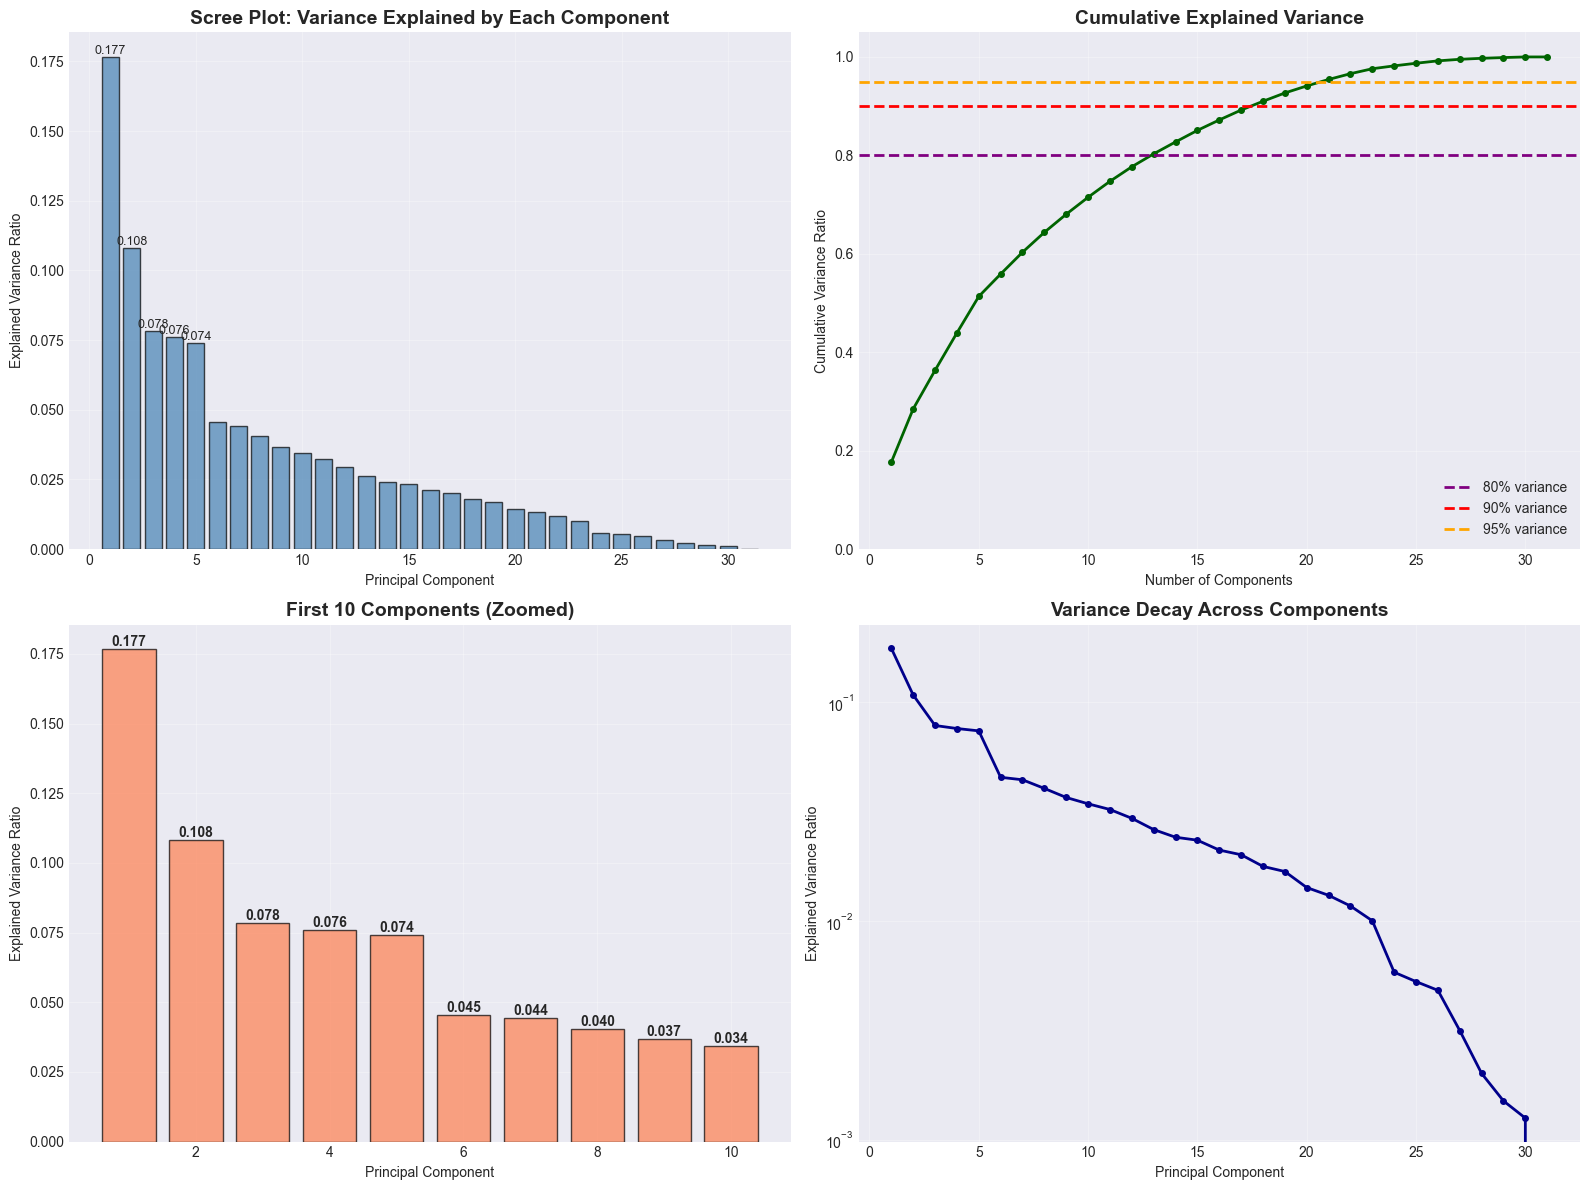

✓ Variance visualizations created


In [5]:
# Create comprehensive variance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scree Plot (Individual variance per component)
axes[0, 0].bar(range(1, n_features + 1), explained_var, color='steelblue', 
               edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Scree Plot: Variance Explained by Each Component', 
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].grid(True, alpha=0.3)

# Add text for top components
for i in range(min(5, n_features)):
    axes[0, 0].text(i+1, explained_var[i], f'{explained_var[i]:.3f}', 
                    ha='center', va='bottom', fontsize=9)

# 2. Cumulative Variance
axes[0, 1].plot(range(1, n_features + 1), cumulative_var, marker='o', 
                linewidth=2, markersize=4, color='darkgreen')
axes[0, 1].axhline(y=0.80, color='purple', linestyle='--', linewidth=2, label='80% variance')
axes[0, 1].axhline(y=0.90, color='red', linestyle='--', linewidth=2, label='90% variance')
axes[0, 1].axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95% variance')
axes[0, 1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Variance Ratio')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1.05])

# 3. First 10 components (zoomed scree plot)
axes[1, 0].bar(range(1, 11), explained_var[:10], color='coral', 
               edgecolor='black', alpha=0.7)
axes[1, 0].set_title('First 10 Components (Zoomed)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Explained Variance Ratio')
axes[1, 0].grid(True, alpha=0.3)

# Add values on bars
for i in range(10):
    axes[1, 0].text(i+1, explained_var[i], f'{explained_var[i]:.3f}', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Variance per component (line plot showing decay)
axes[1, 1].plot(range(1, n_features + 1), explained_var, marker='o', 
                linewidth=2, markersize=4, color='darkblue')
axes[1, 1].set_title('Variance Decay Across Components', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Principal Component')
axes[1, 1].set_ylabel('Explained Variance Ratio')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')  # Log scale to see tail better

plt.tight_layout()
plt.show()

print("✓ Variance visualizations created")

## 5. Analyze Component Loadings

Loadings show which original features contribute most to each principal component.

In [6]:
# Get loadings (components matrix)
loadings = pca_full.components_  # Shape: (n_components, n_features)

# Create DataFrame for easier analysis
loadings_df = pd.DataFrame(
    loadings,
    columns=joint_cols,
    index=[f'PC{i+1}' for i in range(n_features)]
)

print("Principal Component Loadings:")
print("="*60)
print(f"Shape: {loadings_df.shape}")
print(f"\nFirst 3 components, first 5 features:")
print(loadings_df.iloc[:3, :5])

Principal Component Loadings:
Shape: (31, 31)

First 3 components, first 5 features:
     joint_00  joint_01  joint_02  joint_03  joint_04
PC1  0.348604  0.348835  0.384632  0.390216  0.343733
PC2 -0.029418 -0.023902  0.013444  0.020988  0.041845
PC3  0.097479  0.091419  0.050002  0.051507 -0.027746


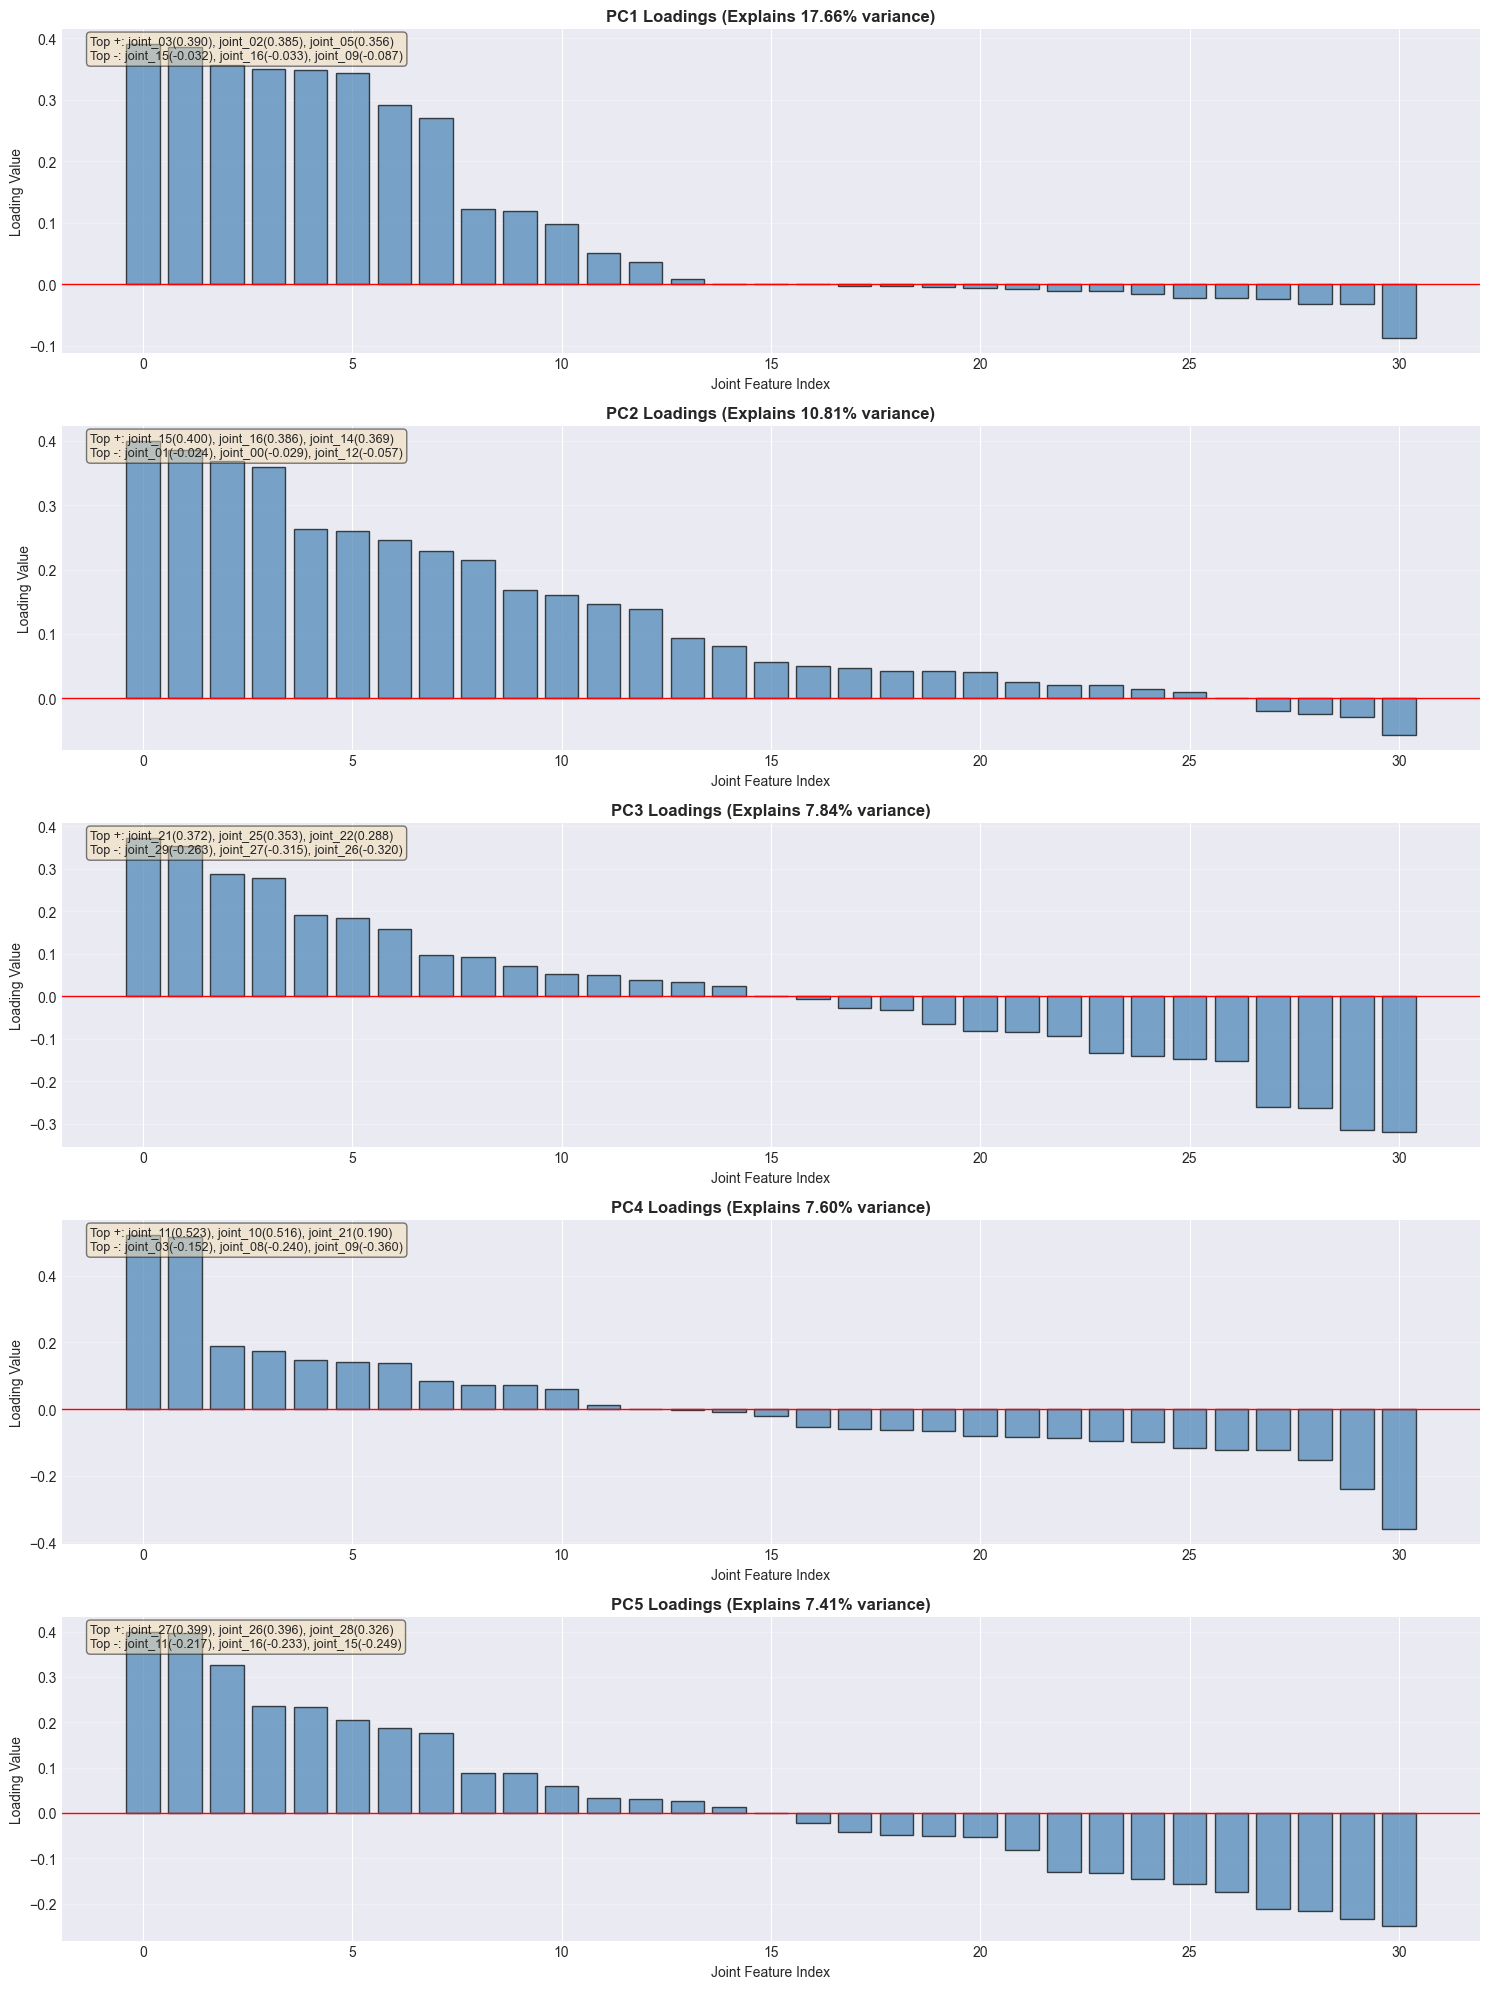

✓ Component loadings visualized


In [7]:
# Visualize loadings for first 5 components
fig, axes = plt.subplots(5, 1, figsize=(15, 20))

for i in range(5):
    pc_loadings = loadings_df.iloc[i].sort_values(ascending=False)
    
    # Plot all loadings
    axes[i].bar(range(len(pc_loadings)), pc_loadings.values, 
                color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].axhline(y=0, color='red', linestyle='-', linewidth=1)
    axes[i].set_title(f'PC{i+1} Loadings (Explains {explained_var[i]*100:.2f}% variance)', 
                      fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Joint Feature Index')
    axes[i].set_ylabel('Loading Value')
    axes[i].grid(True, alpha=0.3, axis='y')
    
    # Highlight top contributors
    top_3 = pc_loadings.head(3)
    bottom_3 = pc_loadings.tail(3)
    
    text_str = f"Top +: {', '.join([f'{idx}({val:.3f})' for idx, val in top_3.items()])}\n"
    text_str += f"Top -: {', '.join([f'{idx}({val:.3f})' for idx, val in bottom_3.items()])}"
    axes[i].text(0.02, 0.98, text_str, transform=axes[i].transAxes,
                verticalalignment='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Component loadings visualized")

In [8]:
# Find most important features for each of first 5 PCs
print("\nTop 5 Contributing Features per Principal Component:")
print("="*60)

for i in range(min(5, n_features)):
    pc_loadings = loadings_df.iloc[i].abs().sort_values(ascending=False)
    print(f"\nPC{i+1} (explains {explained_var[i]*100:.2f}% variance):")
    for rank, (feat, loading) in enumerate(pc_loadings.head(5).items(), 1):
        original_loading = loadings_df.iloc[i][feat]
        print(f"  {rank}. {feat:15} : {original_loading:+.4f} (|{loading:.4f}|)")


Top 5 Contributing Features per Principal Component:

PC1 (explains 17.66% variance):
  1. joint_03        : +0.3902 (|0.3902|)
  2. joint_02        : +0.3846 (|0.3846|)
  3. joint_05        : +0.3556 (|0.3556|)
  4. joint_01        : +0.3488 (|0.3488|)
  5. joint_00        : +0.3486 (|0.3486|)

PC2 (explains 10.81% variance):
  1. joint_15        : +0.3999 (|0.3999|)
  2. joint_16        : +0.3859 (|0.3859|)
  3. joint_14        : +0.3695 (|0.3695|)
  4. joint_13        : +0.3594 (|0.3594|)
  5. joint_18        : +0.2638 (|0.2638|)

PC3 (explains 7.84% variance):
  1. joint_21        : +0.3720 (|0.3720|)
  2. joint_25        : +0.3527 (|0.3527|)
  3. joint_26        : -0.3197 (|0.3197|)
  4. joint_27        : -0.3146 (|0.3146|)
  5. joint_22        : +0.2877 (|0.2877|)

PC4 (explains 7.60% variance):
  1. joint_11        : +0.5229 (|0.5229|)
  2. joint_10        : +0.5165 (|0.5165|)
  3. joint_09        : -0.3603 (|0.3603|)
  4. joint_08        : -0.2402 (|0.2402|)
  5. joint_21     

## 6. Heatmap of Component Loadings

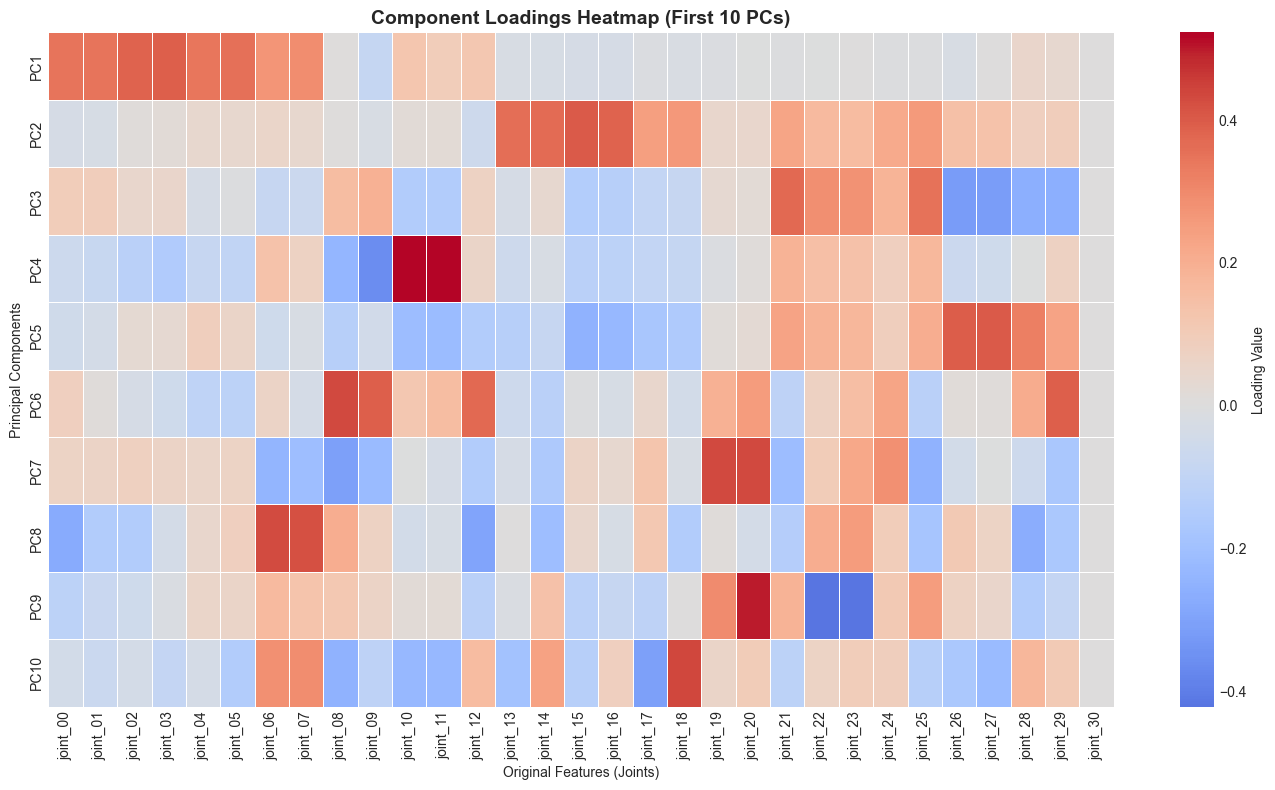

✓ Loadings heatmap created


In [9]:
# Heatmap of first 10 components
n_comps_to_show = min(10, n_features)

plt.figure(figsize=(14, 8))
sns.heatmap(loadings_df.iloc[:n_comps_to_show], 
            cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Loading Value'},
            linewidths=0.5)
plt.title(f'Component Loadings Heatmap (First {n_comps_to_show} PCs)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Original Features (Joints)')
plt.ylabel('Principal Components')
plt.tight_layout()
plt.show()

print("✓ Loadings heatmap created")

## 7. Visualize Data in PC Space (2D Projection)

Project the data onto the first 2 principal components and color by pain level.

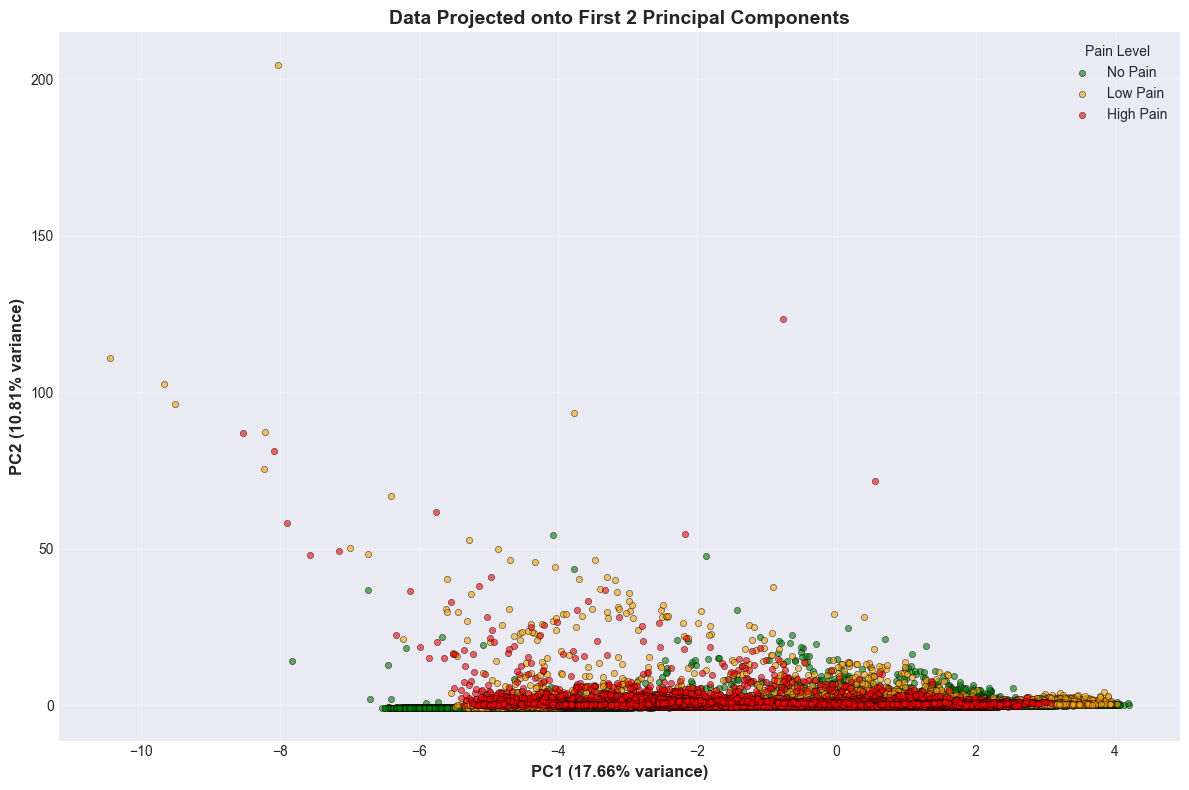

✓ 2D projection shows separation between classes
   PC1+PC2 together explain 28.48% of variance


In [10]:
# Add labels to PCA-transformed data
X_pca_2d = X_pca_full[:, :2]  # First 2 components
labels = train_df['label'].values

# Create scatter plot
plt.figure(figsize=(12, 8))

pain_colors = {'no_pain': 'green', 'low_pain': 'orange', 'high_pain': 'red'}
pain_labels = {'no_pain': 'No Pain', 'low_pain': 'Low Pain', 'high_pain': 'High Pain'}

for pain_level in ['no_pain', 'low_pain', 'high_pain']:
    mask = labels == pain_level
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
               c=pain_colors[pain_level], label=pain_labels[pain_level],
               alpha=0.6, s=20, edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 ({explained_var[0]*100:.2f}% variance)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({explained_var[1]*100:.2f}% variance)', fontsize=12, fontweight='bold')
plt.title('Data Projected onto First 2 Principal Components', fontsize=14, fontweight='bold')
plt.legend(title='Pain Level', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ 2D projection shows separation between classes")
print(f"   PC1+PC2 together explain {cumulative_var[1]*100:.2f}% of variance")

## 8. 3D Visualization (First 3 PCs)

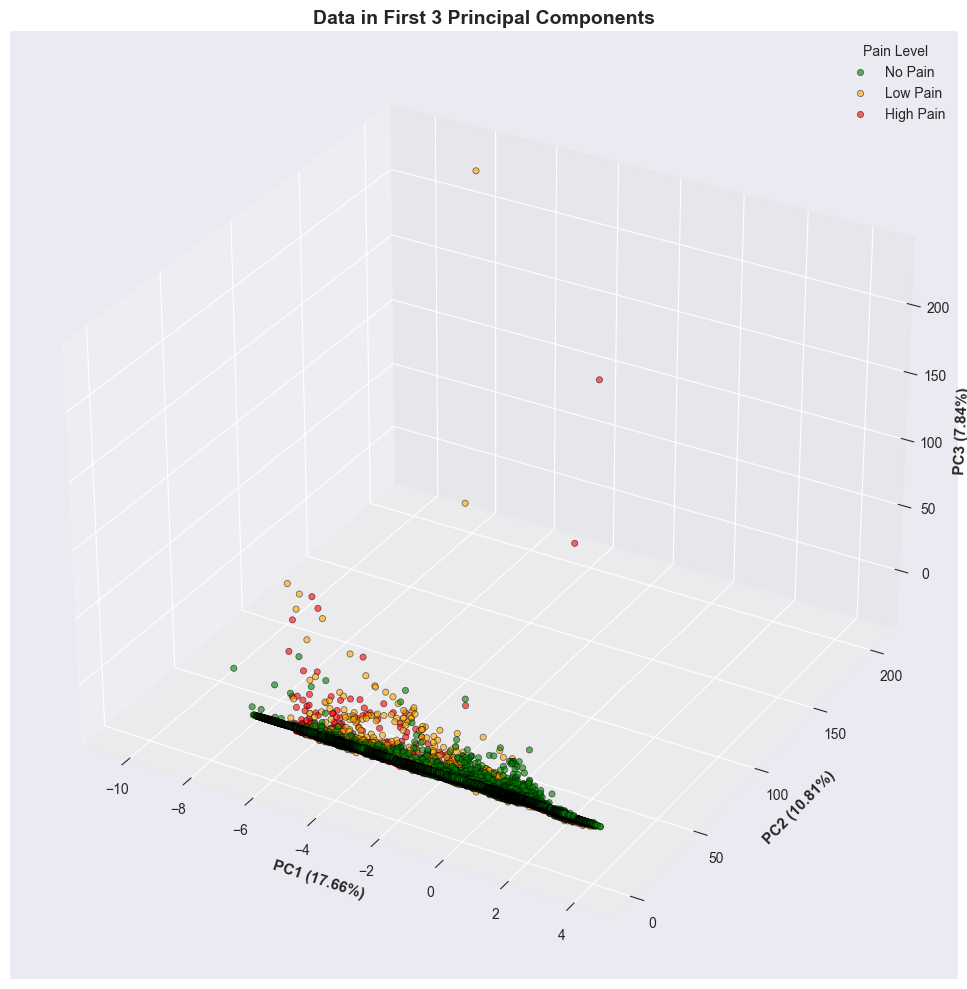

✓ 3D projection complete
   PC1+PC2+PC3 together explain 36.32% of variance


In [11]:
from mpl_toolkits.mplot3d import Axes3D

# 3D projection
X_pca_3d = X_pca_full[:, :3]

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for pain_level in ['no_pain', 'low_pain', 'high_pain']:
    mask = labels == pain_level
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
              c=pain_colors[pain_level], label=pain_labels[pain_level],
              alpha=0.6, s=20, edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({explained_var[0]*100:.2f}%)', fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_var[1]*100:.2f}%)', fontsize=11, fontweight='bold')
ax.set_zlabel(f'PC3 ({explained_var[2]*100:.2f}%)', fontsize=11, fontweight='bold')
ax.set_title('Data in First 3 Principal Components', fontsize=14, fontweight='bold')
ax.legend(title='Pain Level', fontsize=10)
plt.tight_layout()
plt.show()

print(f"✓ 3D projection complete")
print(f"   PC1+PC2+PC3 together explain {cumulative_var[2]*100:.2f}% of variance")

## 9. Class Separation Analysis in PC Space

Analyze how well classes separate in the principal component space.

In [12]:
# Compute per-class statistics in PC space for first 10 components
n_comps = min(10, n_features)
X_pca_subset = X_pca_full[:, :n_comps]

print("Class Statistics in PC Space:")
print("="*60)

for i in range(n_comps):
    print(f"\nPC{i+1}:")
    for pain_level in ['no_pain', 'low_pain', 'high_pain']:
        mask = labels == pain_level
        pc_values = X_pca_subset[mask, i]
        print(f"  {pain_level:12} - Mean: {pc_values.mean():+.4f}, Std: {pc_values.std():.4f}")

Class Statistics in PC Space:

PC1:
  no_pain      - Mean: +0.0027, Std: 2.4317
  low_pain     - Mean: +0.0534, Std: 1.6374
  high_pain    - Mean: -0.1139, Std: 2.0181

PC2:
  no_pain      - Mean: -0.1717, Std: 0.7496
  low_pain     - Mean: +0.5959, Std: 3.6435
  high_pain    - Mean: +0.5666, Std: 3.1128

PC3:
  no_pain      - Mean: +0.1763, Std: 0.8531
  low_pain     - Mean: -0.6039, Std: 2.7371
  high_pain    - Mean: -0.5953, Std: 2.7039

PC4:
  no_pain      - Mean: +0.0310, Std: 1.4077
  low_pain     - Mean: -0.0264, Std: 1.8058
  high_pain    - Mean: -0.2384, Std: 1.8131

PC5:
  no_pain      - Mean: -0.1499, Std: 0.9457
  low_pain     - Mean: +0.4011, Std: 2.6243
  high_pain    - Mean: +0.6949, Std: 2.3609

PC6:
  no_pain      - Mean: -0.0197, Std: 1.0733
  low_pain     - Mean: -0.1273, Std: 1.3354
  high_pain    - Mean: +0.3933, Std: 1.5552

PC7:
  no_pain      - Mean: +0.0373, Std: 1.0724
  low_pain     - Mean: -0.0681, Std: 1.2504
  high_pain    - Mean: -0.2258, Std: 1.5827

PC8

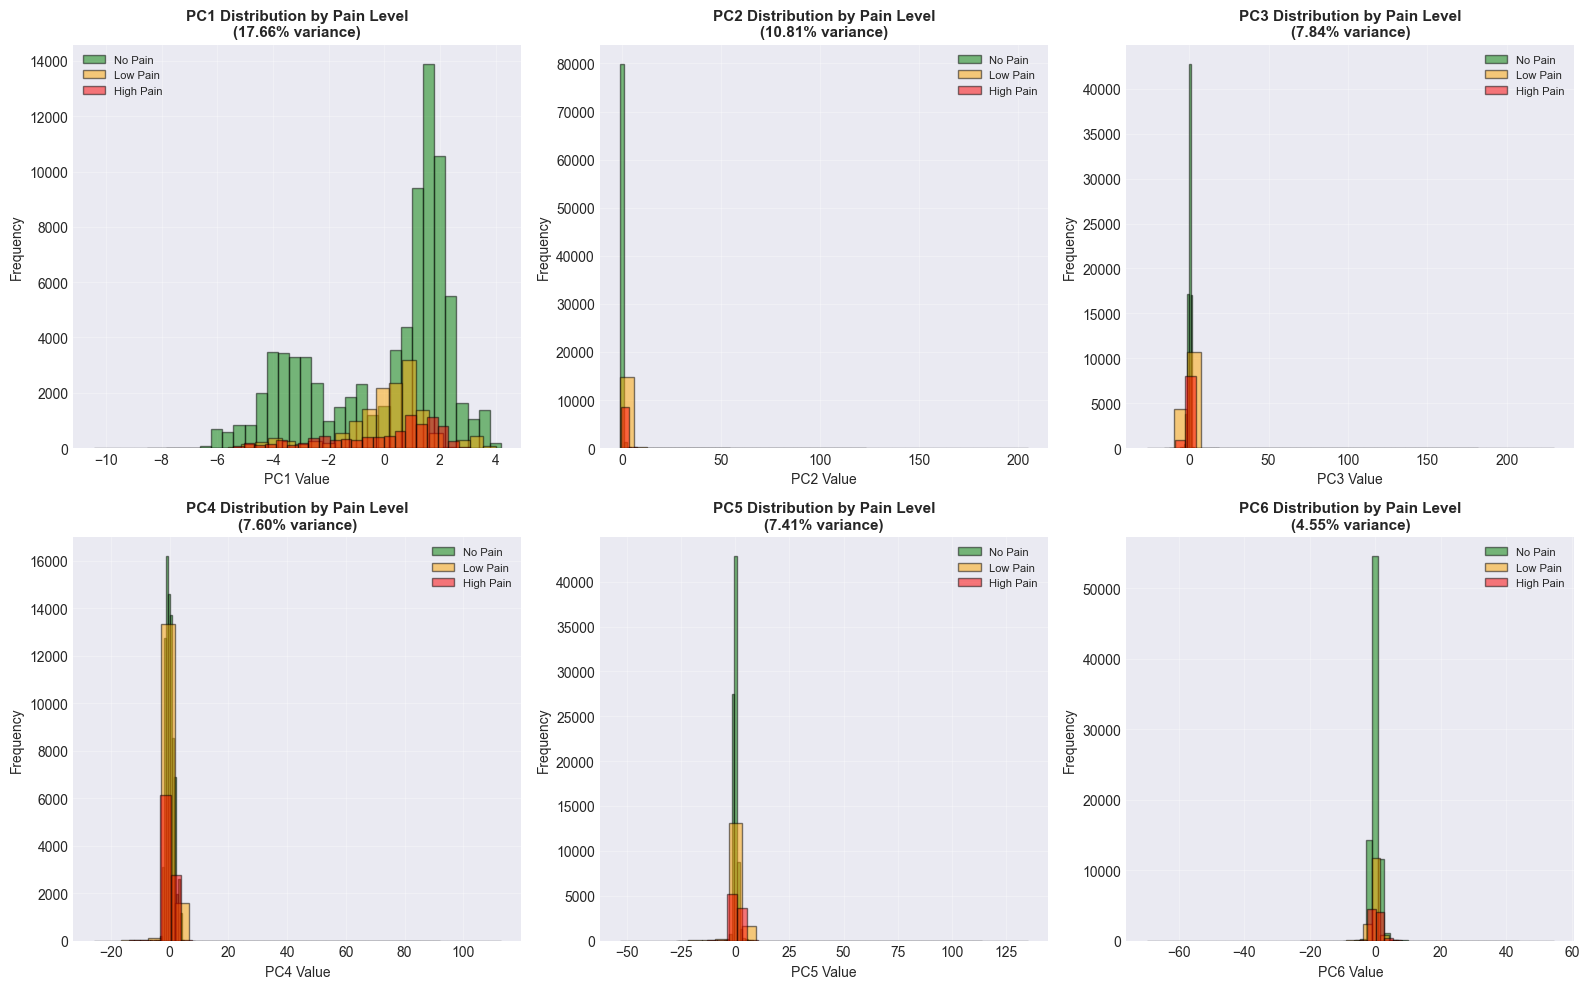

✓ Class distributions in PC space visualized


In [13]:
# Visualize distributions per class for first 6 PCs
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i in range(min(6, n_features)):
    for pain_level, color in pain_colors.items():
        mask = labels == pain_level
        axes[i].hist(X_pca_full[mask, i], bins=30, alpha=0.5, 
                    label=pain_labels[pain_level], color=color, edgecolor='black')
    
    axes[i].set_title(f'PC{i+1} Distribution by Pain Level\n({explained_var[i]*100:.2f}% variance)', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel(f'PC{i+1} Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Class distributions in PC space visualized")

## 10. Reconstruction Error Analysis

Test how well we can reconstruct original data using different numbers of components.

In [14]:
# Calculate reconstruction error for different numbers of components
n_components_to_test = [1, 2, 3, 5, 10, 15, 20, n_features]
reconstruction_errors = []

for n_comp in n_components_to_test:
    if n_comp <= n_features:
        # Use only first n_comp components
        pca_temp = PCA(n_components=n_comp)
        X_transformed = pca_temp.fit_transform(X_scaled)
        X_reconstructed = pca_temp.inverse_transform(X_transformed)
        
        # Calculate MSE
        mse = np.mean((X_scaled - X_reconstructed) ** 2)
        reconstruction_errors.append(mse)
        
        variance_retained = np.sum(pca_temp.explained_variance_ratio_)
        print(f"n_components={n_comp:2d}: MSE={mse:.6f}, Variance retained={variance_retained:.4f}")

print("\n✓ Reconstruction error analysis complete")

n_components= 1: MSE=0.796804, Variance retained=0.1766
n_components= 2: MSE=0.692173, Variance retained=0.2848
n_components= 3: MSE=0.616257, Variance retained=0.3632
n_components= 5: MSE=0.470965, Variance retained=0.5133
n_components=10: MSE=0.275956, Variance retained=0.7148
n_components=15: MSE=0.144412, Variance retained=0.8508
n_components=20: MSE=0.057032, Variance retained=0.9411
n_components=31: MSE=0.000000, Variance retained=1.0000

✓ Reconstruction error analysis complete


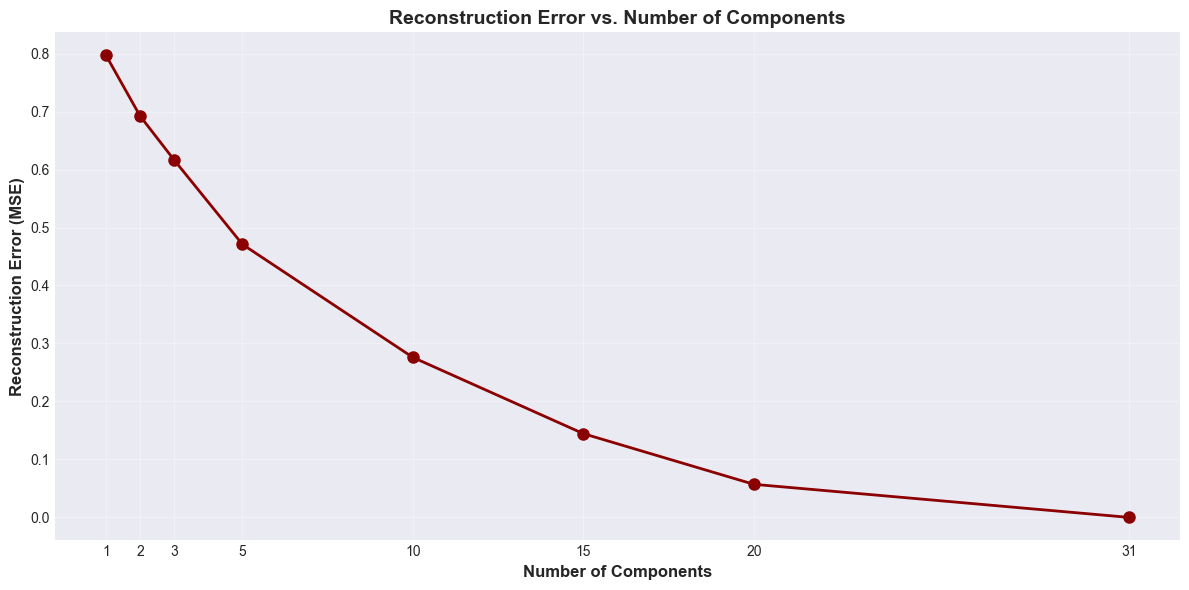

✓ Reconstruction error plot created


In [15]:
# Plot reconstruction error
valid_n_comps = [n for n in n_components_to_test if n <= n_features]

plt.figure(figsize=(12, 6))
plt.plot(valid_n_comps, reconstruction_errors, marker='o', 
         linewidth=2, markersize=8, color='darkred')
plt.xlabel('Number of Components', fontsize=12, fontweight='bold')
plt.ylabel('Reconstruction Error (MSE)', fontsize=12, fontweight='bold')
plt.title('Reconstruction Error vs. Number of Components', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(valid_n_comps)
plt.tight_layout()
plt.show()

print("✓ Reconstruction error plot created")

## 11. Summary & Conclusions

### 📊 Key Findings:

1. **Intrinsic Dimensionality**: 
   - Components needed for 90% variance: [Check output above]
   - Components needed for 95% variance: [Check output above]
   
2. **Feature Redundancy**:
   - If few components needed → Features are highly correlated
   - If many components needed → Features are relatively independent
   
3. **Dominant Patterns**:
   - PC1 variance: [Check output] → Shows strongest pattern
   - Top 3 PCs: [Check output] → Capture main variation modes
   
4. **Class Separation**:
   - Check 2D/3D plots → Are classes well-separated in PC space?
   - If yes → PCA features could improve classification
   - If no → Original features or other transformations needed

### 🎯 Recommendations:

**Option 1: Use PCA-transformed features**
```python
# If PCA shows good compression (e.g., 10 components for 90% variance)
pca = PCA(n_components=0.90)  # or fixed number like n_components=10
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
```

**Option 2: Feature selection based on loadings**
- Identify features with high loadings on important PCs
- Keep those features in original form (more interpretable)

**Option 3: Hybrid approach**
- Use both original features AND top PCs as additional features
- Gives model more flexibility

### ⚠️ Important Notes:

1. **Always standardize** before PCA (we did this)
2. **Fit PCA only on training data**, then transform test data
3. **PCA loses interpretability** - you work with linear combinations
4. **Check class separation** in PC space before deciding to use PCA

### 📁 Next Steps:

1. Compare model performance: Original features vs. PCA features
2. Try different numbers of components (cross-validation)
3. Consider non-linear dimensionality reduction (t-SNE, UMAP) if PCA doesn't separate classes well

In [16]:
# Save results for future reference
pca_results = {
    'n_features': n_features,
    'variance_per_component': explained_var.tolist(),
    'cumulative_variance': cumulative_var.tolist(),
    'n_components_for_80pct': int(np.argmax(cumulative_var >= 0.80) + 1),
    'n_components_for_90pct': int(np.argmax(cumulative_var >= 0.90) + 1),
    'n_components_for_95pct': int(np.argmax(cumulative_var >= 0.95) + 1),
    'n_components_for_99pct': int(np.argmax(cumulative_var >= 0.99) + 1),
}

import json
with open('../pca_analysis_results.json', 'w') as f:
    json.dump(pca_results, f, indent=2)

print("✅ Analysis complete! Results saved to pca_analysis_results.json")
print("\nSummary:")
print("="*60)
for key, value in pca_results.items():
    if isinstance(value, list):
        print(f"{key}: [list of {len(value)} values]")
    else:
        print(f"{key}: {value}")

✅ Analysis complete! Results saved to pca_analysis_results.json

Summary:
n_features: 31
variance_per_component: [list of 31 values]
cumulative_variance: [list of 31 values]
n_components_for_80pct: 13
n_components_for_90pct: 18
n_components_for_95pct: 21
n_components_for_99pct: 26
